# Titanic Kaggle competition    
 
 Polynomial Paracress - 02/10/2023

<a id='TOC'/>

### TOC (table of content)
1. [Load packages](#loading_packages)
2. [Load data](#data_loading)
3. [EDA technical](#EDA_technical)
4. [EDA information](#EDA_info)
5. [Feature engineering](#feature_engineering)
6. [Dummy Classifier](#dummy)
7. [Pipeline + ColumnTransformer](#pipeline)
8. [Evaluation](#evaluation)
9. [Additional Links](#links)
---
10. [Cross-validation](#crossval)
11. [GridSearchCV](#gridsearch)
12. [Set Kaggle solution](#kaggle)

<a id='loading_packages'/>

### Loading packages
[TOC](#TOC)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# bin numerical data, scale data, encode data
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler, OneHotEncoder  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

<a id='data_loading'/>

### Loading data
[TOC](#TOC)

Use shell commands with !

In [2]:
!pwd

'pwd' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [3]:
df = pd.read_csv('train_titanic.csv') # take care of the format of the file (separaters, metadata, headers...)

Check, if the data got imported nicely and try to understand the columns (column names)    

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Since Kaggle uses the PassengerId to map the correct prediction, we should use the PassengerId as Index

In [6]:
df.set_index('PassengerId', inplace=True)

<a id='EDA_technical'/>

### EDA (exploratory data analysis)
1. Data integrity (technical analysis)    
Missing values, data types, duplicates, base statitics
2. Informational analysis     
Correlations (target needs to be DEPENDENT variables, features should be INDEPENDENT variables)     
Think about causality and correlation    

[TOC](#TOC)

Check for missing values (keep in mind there could be a pattern, e.g. missing values for 3rd class passengers)    
Be aware that the EDA will take much more time than the actual model and is SUPER important for the outcome 

In [7]:
df.isnull().sum()  # isna() is doing exactly the same thing

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

One way of getting insights about the patterns of missing values (use `isna()` to get a MASK)

In [8]:
df[df['Age'].isnull()].value_counts('Pclass')

Pclass
3    136
1     30
2     11
Name: count, dtype: int64

How many entries do we have? 891!

In [9]:
df.shape

(891, 11)

Check for duplicates

In [10]:
df.duplicated().sum()

0

Learn about the datatypes

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Learn about the statistics

In [12]:
df.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Insights technical analysis:
- We have missing values in `Age`, a huge lot in `Cabin` and only 2 in `Embarked`
- We have NO duplicates in the data
- We checked the data types and the base statistics

<a id='EDA_info'/>

### EDA (information)
[TOC](#TOC)

<Axes: >

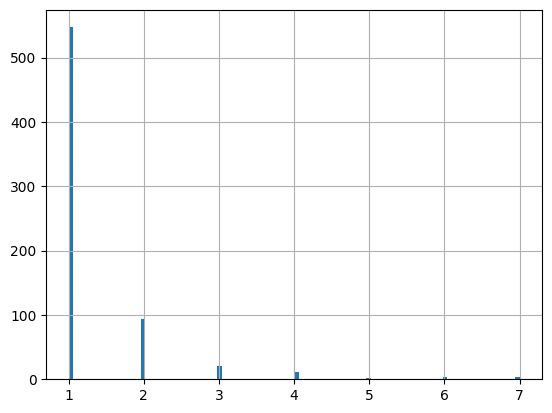

In [13]:
df.value_counts('Ticket').hist(bins=100)

We suspect correlation between the survival and ALL features (target is dependent)     
We suspect correlation between many features (e.g. Fare, Pclass or Sex, Ticket, Family on board, etc...), 

Be careful to not go too deep into imagine feautures BUT(!!) don't take the EDA too lightly!!    
Please don't do a single Pearson correlation matrix and think you're done!

C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.

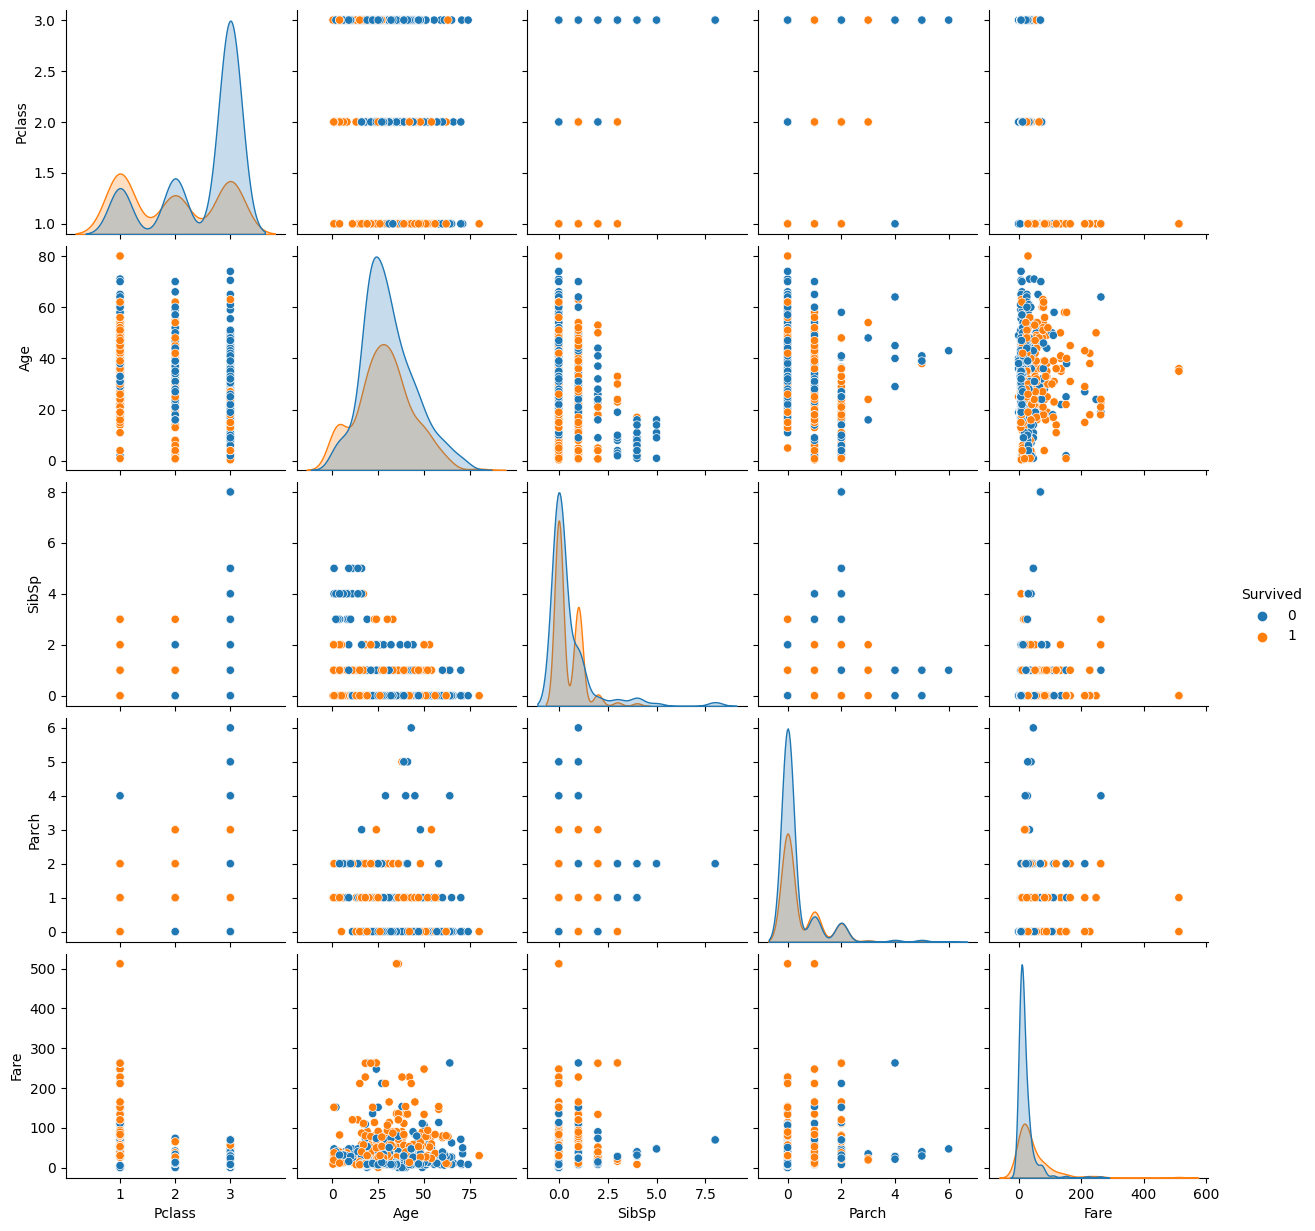

In [14]:
sns.pairplot(df, hue='Survived')  
# by doing the pairplot (pairwise scatter plot of features) with the color-coded target 
# you can get a lot of insights into the data distribution

C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.

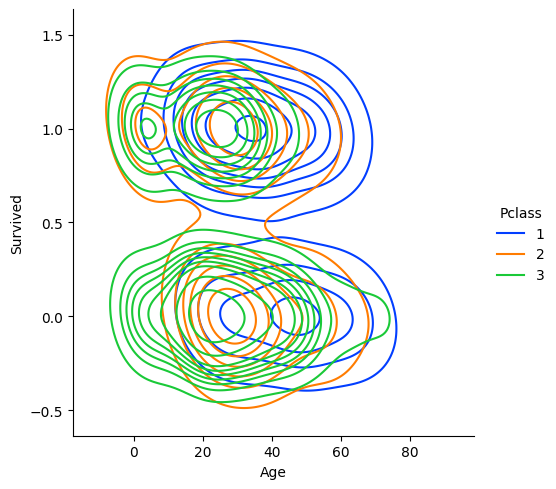

In [15]:
sns.displot(data=df, x='Age', y='Survived', hue='Pclass', kind='kde', palette='bright')

C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.

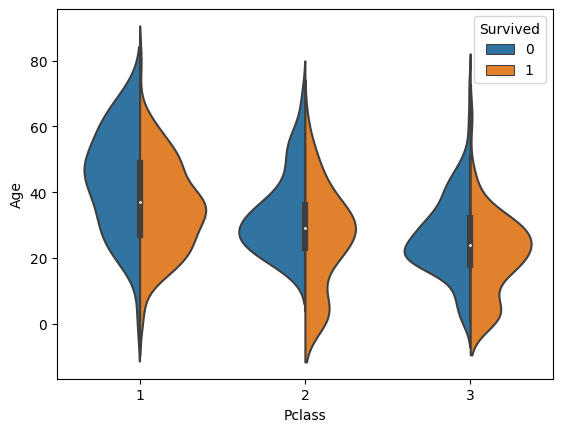

In [16]:
sns.violinplot(data=df, x='Pclass', y='Age', hue='Survived', split=True);

<Axes: >

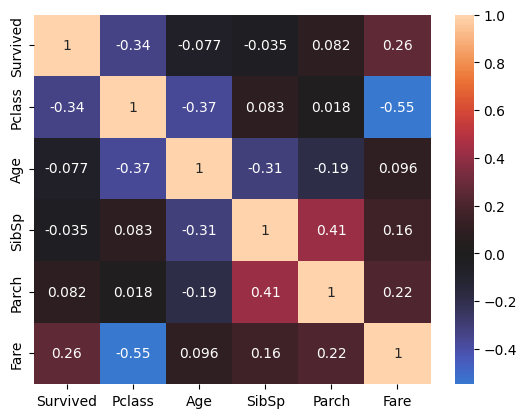

In [17]:
sns.heatmap(df.corr(numeric_only=True), annot=True, center=0)

Make the plots that make your case, be creative, there are plenty of nice visualizations    
Check for more plots at https://datavizproject.com

<a id='feature_engineering'/>

Question: what are StandardScaler and MinMaxScaler do?     
- Standardscaler is subtracting the mean and divides by the SD, puts the values around 0 with a variance/SD of 1
- MinMaxScaler is putting the values between 0 and 1 (and keeps the shape of the distribution)

### Feature engineering
1. Treat missing values    
Drop samples, drop the feature, impute them (mean/median/mode, draw numbers from the same distribution, conditional values - kNN k-nearest neighbors im feature space) 
2. Decide with features to use    
We would need to check (statistical test) if `Fare` and `Pclass` are very highly correlated and which one to use!
3. Decide on a model     
Logistic Regression, kNN Classifier (take the majority value of the k nearest neighbors)
4. Treat the features accordingly     
`Pclass` - OHE (one-hot-encode)    
`Name` - drop (length, extract title, ...)    
`Sex` - OHE     
`Age` - SimpleImputer/kNNImputer, kBinDiscretizer (automatically OHE)  [maybe PolynomialFeature]         
`Ticket` - KBinDiscretizer (OHE) - be aware of turn it into numbers first!!      
`Fare` - MinMaxScaler    
`Cabin` - drop (take the first letter which is the deck, impute U - unkown for missing values)   
`Embarked` - SimpleImpute with mode (maybe drop)   
`Family` - sum SibSp + ParCh + 1 (number of family members on board incl. yourself)    
    - `SibSp` - KBinDiscretizer (OHE probably not ideal because it would not cover unseen numbers)    
    - `ParCh` - KBinDiscretizer (OHE probably not ideal because it would not cover unseen numbers)

[TOC](#TOC)

<a id='dummy'/>

### DummyModel
Baseline model     
[TOC](#TOC)

In [27]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [28]:
dummy.score(X_train, y_train)

0.6287425149700598

In [29]:
dummy.score(X_test, y_test)

0.57847533632287

In [30]:
dummy.predict(X_test)  # everyone is dead, because it was the most frequent value in y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

<a id='pipeline'/>

### Pipeline + ColumnTransformer
[TOC](#TOC)

`Pipeline` - use several transformers or the model in one go (one pipeline)    
`ColumnTransformer` - use transformers on a specific columns/feature

In [19]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [20]:
## family column = sum (SibSp + ParCh + 1)
# we do this on X since we don't want to change df
X['Family'] = X['SibSp'] + X['Parch'] + 1
X.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)  # think about stratify, here not needed

Pipeline

In [22]:
pipeline_age = Pipeline([('age_imputer', KNNImputer()),   # list of pairs (name, transformer)
                         ('age_bin', KBinsDiscretizer())])

In [23]:
pipeline_embarked = Pipeline([('embark_impute', SimpleImputer(strategy='most_frequent')),
                             ('embark_ohe', OneHotEncoder())])

ColumnTransformer

In [24]:
my_column_transfomer = ColumnTransformer([('ohe', OneHotEncoder(), ['Pclass', 'Sex']),
                                         ('bin', KBinsDiscretizer(), ['Family']),
                                         ('age', pipeline_age, ['Age']),
                                         ('minmax', MinMaxScaler(), ['Fare']),
                                         ('simple', pipeline_embarked, ['Embarked']),
                                         ], remainder='drop')

# remainder = everything not mentioned in the ColumnTransformer 
# `drop` = don't use them, `passthrough` - use them as they are

In [25]:
pipeline_model = Pipeline([('ct', my_column_transfomer),
                          ('model', KNeighborsClassifier()),])

`pipeline_age` - is purely transforming - fit_transform        
`pipeline_model` - contains a model - fit_predict

In [26]:
pipeline_model.fit(X_train, y_train)

C:\users\ronni\spiced\challenge\FI_Africa\Financial_Inclusion_in_Africa\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['Pclass', 'Sex']),
                                                 ('bin', KBinsDiscretizer(),
                                                  ['Family']),
                                                 ('age',
                                                  Pipeline(steps=[('age_imputer',
                                                                   KNNImputer()),
                                                                  ('age_bin',
                                                                   KBinsDiscretizer())]),
                                                  ['Age']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['Fare']),
                                                 ('simple',
                                                  Pipeline(steps=[('embark_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('embark_ohe',
                                                                   OneHotEncoder())]),
                                                  ['Embarked'])])),
                ('model', KNeighborsClassifier())])

<a id='evaluation'/>

### Evaluation 
[TOC](#TOC)

In [31]:
pipeline_model.score(X_train, y_train)

0.8413173652694611

In [32]:
pipeline_model.score(X_test, y_test)

0.7802690582959642

<a id='links'/>

Confusion matrix for DummyClassifier

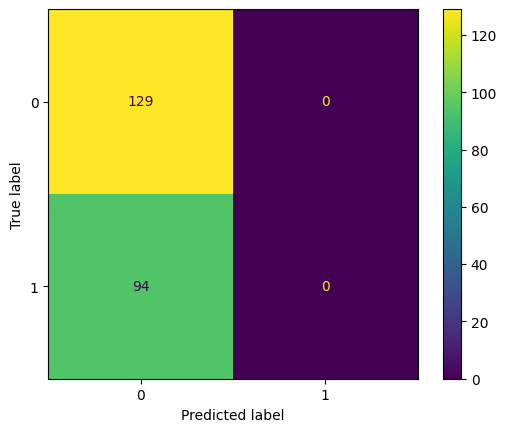

In [33]:
confusion_matrix_dummy = ConfusionMatrixDisplay(confusion_matrix(y_test, dummy.predict(X_test)))
confusion_matrix_dummy.plot()

Confusion matrix for our model

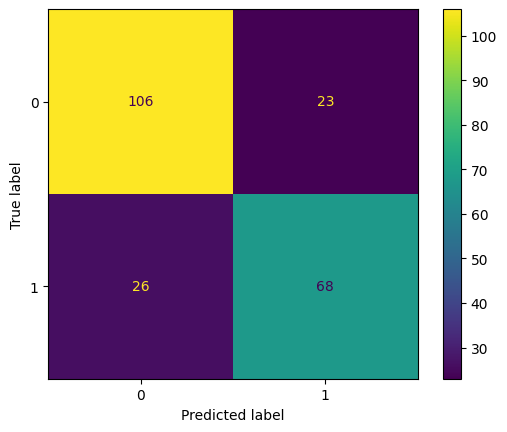

In [34]:
confusion_matrix_model = ConfusionMatrixDisplay(confusion_matrix(y_test, pipeline_model.predict(X_test)))
confusion_matrix_model.plot()

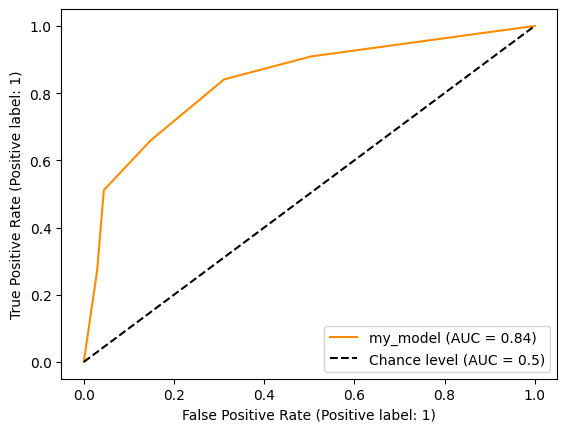

In [47]:
RocCurveDisplay.from_predictions(y_test, pipeline_model.predict_proba(X_test)[:,1], # you give here the probabilities of the positive class
                                color="darkorange",
                                name='my_model',
                                plot_chance_level=True)

In [48]:
print('Classification report for dummy classifier\n\n', classification_report(y_test, dummy.predict(X_test), zero_division=0.0))

Classification report for dummy classifier

               precision    recall  f1-score   support

           0       0.61      1.00      0.75       135
           1       0.00      0.00      0.00        88

    accuracy                           0.61       223
   macro avg       0.30      0.50      0.38       223
weighted avg       0.37      0.61      0.46       223



In [49]:
print('Classification report for my_model\n\n', classification_report(y_test, pipeline_model.predict(X_test),))

Classification report for my_model

               precision    recall  f1-score   support

           0       0.79      0.85      0.82       135
           1       0.74      0.66      0.70        88

    accuracy                           0.78       223
   macro avg       0.77      0.76      0.76       223
weighted avg       0.77      0.78      0.77       223



<a id='crossval'/>

### Cross-validation
[TOC](#TOC)

In [50]:
cross_val_score(pipeline_model, X_train, y_train, n_jobs=-1, cv=5)  # -1 - use all CPUs you have

/Users/hahn/venv/nf/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/hahn/venv/nf/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/hahn/venv/nf/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/hahn/venv/nf/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/hahn/venv/nf/lib/python3.11/site-packages

array([0.7238806 , 0.78358209, 0.79104478, 0.81203008, 0.78947368])

<a id='gridsearch'/>

### GridSearchCV
[TOC](#TOC)

Use this to find the names of your parameters and their current value

In [1]:
pipeline_model.get_params()

NameError: name 'pipeline_model' is not defined

Set the values for each paramter you would like to check

In [66]:
params_dict = {'ct__age__age_bin__n_bins': [3, 5, 8],
              'model__n_neighbors': [5, 10]}

In [69]:
gridsearch = GridSearchCV(pipeline_model, params_dict, cv=5, n_jobs=-1)

In [70]:
gridsearch.fit(X_train, y_train)

/Users/hahn/venv/nf/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/hahn/venv/nf/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/hahn/venv/nf/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/hahn/venv/nf/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/hahn/venv/nf/lib/python3.11/site-packages

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['Pclass',
                                                                          'Sex']),
                                                                        ('bin',
                                                                         KBinsDiscretizer(),
                                                                         ['Family']),
                                                                        ('age',
                                                                         Pipeline(steps=[('age_imputer',
                                                                                          KNNImputer()),
                                                                                         ('age_bin',
                                                                                          KBinsDiscretizer())]),
                                                                         ['Age']),
                                                                        ('minmax',
                                                                         MinMaxScaler(),
                                                                         ['Fare']),
                                                                        ('simple',
                                                                         Pipeline(steps=[('embark_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('embark_ohe',
                                                                                          OneHotEncoder())]),
                                                                         ['Embarked'])])),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'ct__age__age_bin__n_bins': [3, 5, 8],
                         'model__n_neighbors': [5, 10]})

Display the best parameter set

In [71]:
gridsearch.best_params_

{'ct__age__age_bin__n_bins': 8, 'model__n_neighbors': 10}

Call the estimator (model) with the best parameter set

In [74]:
gridsearch.best_estimator_.predict(X_test)

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0])

Score (accuracy) the test data set

In [72]:
gridsearch.best_estimator_.score(X_test, y_test)

0.8071748878923767

Get the whole info about the CVs

In [73]:
gridsearch.cv_results_

{'mean_fit_time': array([0.00796657, 0.01481929, 0.0098    , 0.00801044, 0.00887752,
        0.00734978]),
 'std_fit_time': array([0.00066293, 0.00181996, 0.00328197, 0.00159351, 0.00291733,
        0.001433  ]),
 'mean_score_time': array([0.00725331, 0.01019678, 0.00573931, 0.00468116, 0.00332026,
        0.00386138]),
 'std_score_time': array([1.42913275e-03, 3.76412078e-03, 1.14921935e-03, 1.47260051e-03,
        6.59118328e-05, 1.06265738e-03]),
 'param_ct__age__age_bin__n_bins': masked_array(data=[3, 3, 5, 5, 8, 8],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_model__n_neighbors': masked_array(data=[5, 10, 5, 10, 5, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'ct__age__age_bin__n_bins': 3, 'model__n_neighbors': 5},
  {'ct__age__age_bin__n_bins': 3, 'model__n_neighbors': 10},
  {'ct__age__age_bin__n_bins': 5, 'model__

<a id='kaggle'/>

### Kaggle competition
[TOC](#TOC)

In [78]:
df_kaggle = pd.read_csv('test.csv', index_col=0)

In [91]:
df_kaggle.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
family        0
Family        0
dtype: int64

Add the `family` column manually!

In [85]:
df_kaggle['Family'] = df_kaggle['SibSp'] + df_kaggle['Parch'] + 1

In [101]:
X_kaggle_test = df_kaggle.copy()

### !!!WARNING:     
Since we have a missing value in the test data from Kaggle in `Fare` we would have to include an Imputer to the pipeline, otherwise we can't make a prediction! Here, we do it by hand only for the test set because we had no time to discuss it and I don't want to change the stuff we did together. This is not the way you should do it ...     
### NEVER EVER!!

In [102]:
X_kaggle_test['Fare'] = X_kaggle_test['Fare'].astype('float')
median_fare = X_kaggle_test['Fare'].median(skipna=True)
X_kaggle_test['Fare'].fillna(median_fare, inplace=True)  # NEVER EVER! Dirty hack! 

In [104]:
prediction = gridsearch.best_estimator_.predict(X_kaggle_test)

In [110]:
df_prediction = pd.DataFrame(prediction, index=X_kaggle_test.index)

In [112]:
df_prediction.to_csv('my_kaggle_prediction.csv')

### Links
[TOC](#TOC)

- [The Kaggle competition](https://www.kaggle.com/competitions/titanic)
- [Which score is good?](https://www.kaggle.com/code/carlmcbrideellis/titanic-leaderboard-a-score-0-8-is-great)
- [Confusion Matrix of Titanic](https://www.kaggle.com/code/carlmcbrideellis/titanic-in-all-the-confusion/notebook)